In [1]:
# import standard libraries
import pandas as pd
import numpy as np
import datetime as dt

# import data scraping tools
import yfinance as yf

# import statistical tools
from scipy.stats import norm, t

# import graphing tools
import plotly.graph_objects as go
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

### The code block below is a list of functions used in calculating the Value at Risk for a known Portfolio (this means the assets in the portfolio and relative weight are known).

In [2]:
# Gets daily data on the listed stocks from the start til the end time
def retrieve_data(asset, start, end):
    data = yf.download(asset, start=start, end=end, progress = False)
    prices = data['Close']
    returns = prices.pct_change()
    return returns

# Creates a Monte Carlo simulation of the returns to the initial portfolio 
def create_MonteCarlo_simulation(num_sims, timeframe, weights, returns, initial_portfolio_value):
    """
    Credits: https://github.com/TheQuantPy for his algorithm of calculating the Monte Carlo simulation.
    The rationale for using his code and how it works is included in the markdown file Rationale
    """
    meanM = np.full(shape=(timeframe, len(weights)), fill_value=returns.mean())
    meanM = meanM.T

    portfolio_sims = np.full(shape=(timeframe, num_sims), fill_value=0.0)
    
    for m in range(0, num_sims):
        Z = np.random.normal(size=(timeframe, len(weights)))
        L = np.linalg.cholesky(returns.cov())
        dailyReturns = meanM + np.inner(L, Z)
        portfolio_sims[:,m] = np.cumprod(np.inner(weights, dailyReturns.T)+1)*initial_portfolio_value
        
    plt.plot(portfolio_sims)
    plt.ylabel('Portfolio Value ($)')
    plt.xlabel('Days')
    plt.title(f'Monte Carlo simulation of a portfolio with following assets {returns_df.columns.to_list()}')
    plt.show()
    
    return pd.Series(portfolio_sims[-1,:])

# Get potential portfolio value at the alpha-th percentile
def get_VaR_threshold(returns, alpha):
    return np.percentile(returns, alpha)

# Get mean value of portfolio value past the alpha-th percentile
def get_CVaR_threshold(returns, alpha):
    return returns[returns <= get_VaR_threshold(returns, alpha=alpha)].mean()
    
# Graph the potential portfolio value highlighting the VaR and CVaR at given alpha
def show_potential_portfolio_value(df, VaR_thresh, CVaR_thresh, VaR, CVaR, timeframe, alpha):
    sns.set(style="whitegrid")
    plt.figure(figsize=(8, 6))

    sns.kdeplot(df, fill=True, color='skyblue', alpha = 0.7)

    x_values = sns.kdeplot(df).get_lines()[0].get_data()[0]
    y_values = sns.kdeplot(df).get_lines()[0].get_data()[1]
    plt.fill_between(x_values, 0, y_values,
                     where=(x_values <= VaR_thresh),
                     color='red', alpha=0.3, label=f'Shaded Area (x < {VaR_thresh})')

    plt.axvline(VaR_thresh, color='blue', linestyle='--', label=f'VaR = ${VaR}')
    plt.axvline(CVaR_thresh, color='green', linestyle='--', label=f'CVaR = ${CVaR}')

    plt.title(f'Potential Portfolio Values after {timeframe} days (alpha = {alpha})')
    plt.xlabel('Portfolio Value ($)')
    plt.ylabel('Density')

    plt.legend()
    plt.show()

### To use just adjust the values listed below

In [6]:
# List of stocks
assetList = ['VOO', 'AMZN', 'FLXI.L']

# Weights of the stocks
#weights = [1 / len(assetList)] * len(assetList)
weights = [0.80, 0.10, 0.10]

# Time Periods
endDate = dt.datetime.now()
startDate = endDate - dt.timedelta(days=365*5)

# Number of simulations run for Monte Carlo
num_sims = 10000

# Timeframe of simulation (days)
timeframe = 100

# Current Portfolio Vlaue
current_portfolio_value = 10000

# Alpha or tolerance level (expressed as a number from 1-100)
alpha = 25

### After modifying the inputs above, just run the code below

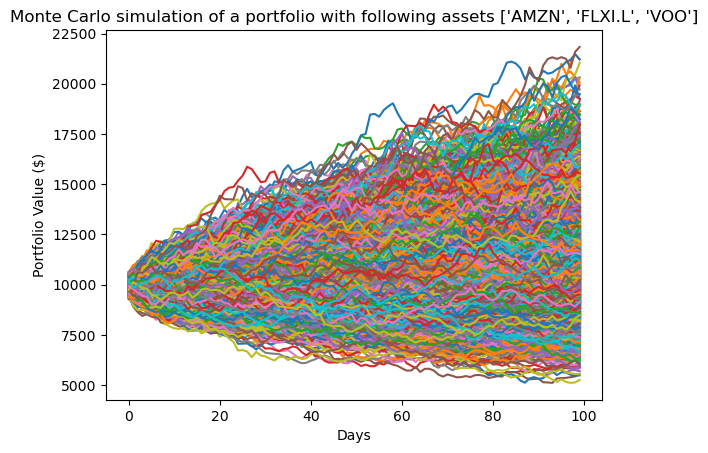

In [4]:
"""
No need to modify code beneath this point just run and the results will show

Code below gets the data on the closing prices of the assets in the list of assets
and runs a Monte Carlo Simulation based on the historical returns

NOTE: Rerunning this code block will result in a new monte carlo simulation so if you want to adjust the alpha level on the same simulation, run this once and just modify the code block below
"""
returns_df = retrieve_data(assetList, startDate, endDate)

mc_simulation_df = create_MonteCarlo_simulation(num_sims = num_sims, timeframe = timeframe, weights = weights, returns = returns_df, initial_portfolio_value = current_portfolio_value)

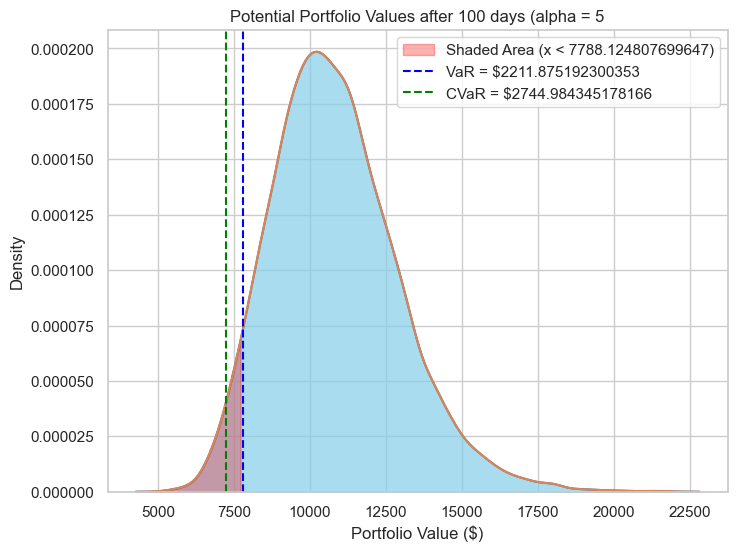

In [5]:
"""

Code below finds the portfolio value given the alpha level or risk tolerance
and then calculate the VaR and CVaR values

"""
VaRportfolio_value_at_alpha = get_VaR_threshold(mc_simulation_df, alpha=alpha)
CVaRportfolio_value_at_alpha = get_CVaR_threshold(mc_simulation_df, alpha=alpha)

VaR = current_portfolio_value - VaRportfolio_value_at_alpha

CVaR = current_portfolio_value - CVaRportfolio_value_at_alpha

show_potential_portfolio_value(mc_simulation_df, VaRportfolio_value_at_alpha, CVaRportfolio_value_at_alpha, VaR, CVaR, timeframe, alpha)